In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import gudhi as gh
import networkx as nx


import itertools

import meshplot as mp
import matplotlib.pyplot as plt

# Create Shapes

In [2]:
def merge_meshes_with_weld(V0, F0, V1, F1, tol=1e-9):
    """
    Объединяет 2 меша и 'сваривает' совпадающие вершины.
    V*: (N,3) float, F*: (M,3) int (0-based).
    tol: геом. допуск (в тех же единицах, что и координаты).

    Возвращает: V_merged, F_merged, (map0, map1)
      map0: отображение старых индексов V0 -> новых индексов
      map1: отображение старых индексов V1 -> новых индексов
    """
    # 1) складываем вершины в один массив
    V = np.vstack([V0, V1])

    # 2) квантизация (устойчивая сварка для float)
    #    ключ = округление координат к сетке tol
    if tol <= 0:
        raise ValueError("tol must be > 0")
    Q = np.round(V / tol).astype(np.int64)

    # 3) unique по строкам: получаем новые вершины и отображение old->new
    #    inv[i] = индекс уникальной вершины для старой вершины i
    uniqQ, uniq_idx, inv = np.unique(Q, axis=0, return_index=True, return_inverse=True)

    V_merged = V[uniq_idx]

    # 4) перенумеровываем грани
    F0_new = inv[F0]
    F1_shifted = F1 + len(V0)
    F1_new = inv[F1_shifted]

    F_merged = np.vstack([F0_new, F1_new])

    # (опционально) убрать вырожденные треугольники, которые могли появиться после сварки
    # например, если два или три индекса в треугольнике совпали
    good = (F_merged[:,0] != F_merged[:,1]) & (F_merged[:,1] != F_merged[:,2]) & (F_merged[:,0] != F_merged[:,2])
    F_merged = F_merged[good]

    map0 = inv[:len(V0)]
    map1 = inv[len(V0):]

    return V_merged, F_merged, (map0, map1)

In [3]:
def rotate_over_x(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[1, 0, 0],
                  [0, c, -s],
                  [0, s,  c]])
    return points @ R.T

def rotate_over_y(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, 0, s],
                  [0, 1, 0],
                  [-s, 0, c]])
    return points @ R.T

def rotate_over_z(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    R = np.array([[c, -s, 0],
                  [s,  c, 0],
                  [0,  0, 1]])
    return points @ R.T

## Glued Torus

In [4]:
def get_tor_cords(phi, psi, R=2, r=1):
    x = (R + r*np.cos(psi)) * np.cos(phi)
    y = (R + r*np.cos(psi)) * np.sin(phi)
    z = r * np.sin(psi)
    return np.column_stack([x, y, z])


In [5]:
def get_torus_triangulation(n, m):
    faces = []
    for x, y, in itertools.product(range(n), range(m)):
        v00 = m*x + y
        v01 = m*((x + 1)%n) + y
        v10 = m*x + (y + 1)%m
        v11 = m*((x + 1)%n) + (y + 1)%m
        if (x + y)%2 == 0:
            faces.append([v00, v01, v11])
            faces.append([v00, v10, v11])
        else:
            faces.append([v00, v01, v10])
            faces.append([v01, v10, v11])
    
    faces = np.array(faces)
    return faces

In [6]:
n = 36
m = 24

phi = np.arange(n)/n*2*np.pi
psi = np.arange(m)/m*2*np.pi
phi = np.repeat(phi, m)
psi = np.tile(psi, n)

R, r = 2, 1
glued_torus_vertices = get_tor_cords(phi, psi, R, r)
glued_torus_faces = get_torus_triangulation(n, m)

# glue the hole
disk_border_idx = np.argwhere(abs(np.linalg.norm(glued_torus_vertices, axis=1) - r) < 1e-5).ravel()
disk_border_pts = glued_torus_vertices[disk_border_idx][:, [0, 1]]
disk_triangulation_local = sp.spatial.Delaunay(disk_border_pts).simplices
disk_triangulation_global = disk_border_idx[disk_triangulation_local]
glued_torus_faces = np.vstack([glued_torus_faces, disk_triangulation_global])




mp.plot(glued_torus_vertices, glued_torus_faces, c=np.array([0.5, 0.5, 1.0]), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## 2 Linked Tori

In [7]:
n0, n1 = 24, 36
r0, r1 = 0.4, 0.6

alpha0 = 2*np.pi/n0
alpha1 = 2*np.pi/n1
phi0 = alpha0*np.arange(n0)
phi1 = alpha1*np.arange(n1)
circle0 = np.column_stack([-r0*np.cos(phi0) + r0, r0*np.sin(phi0), np.zeros(n0)])
circle1 = np.column_stack([+r1*np.cos(phi1) - r1, np.zeros(n1), r1*np.sin(phi1)])


torus0_vertices = np.concatenate([rotate_over_y(circle0 + np.array([r1, 0, 0]), i*alpha1) - np.array([r1, 0, 0]) for i in range(n1)])
torus1_vertices = np.concatenate([rotate_over_z(circle1 + np.array([-r0, 0, 0]), i*alpha0) + np.array([r0, 0, 0])for i in range(n0)])

torus0_faces = get_torus_triangulation(n1, n0)
torus1_faces = get_torus_triangulation(n0, n1)

p = mp.plot(torus0_vertices, torus0_faces, c=np.array([1.0, 0.5, 0.5]), shading={"wireframe": True})
p.add_mesh(torus1_vertices, torus1_faces, c=np.array([0.5, 0.5, 1.0]), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.599999…

1

In [8]:
linked_tori_vertices, linked_tori_faces, (map0, map1) = merge_meshes_with_weld(torus0_vertices, torus0_faces, torus1_vertices, torus1_faces, tol=1e-8)

mp.plot(linked_tori_vertices, linked_tori_faces, c=np.array([1.0, 0.5, 1.0]), shading={"wireframe": True})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## 3 Glued halftori


In [9]:
def get_halftorus(r=1, R=2, l0=1, l1=2, n=24, m=36, glue=True, tol=1e-6):
    """
    """
    phi = np.arange(n)/(n - 1)*np.pi
    psi = np.arange(m)/m*2*np.pi

    vertices_torus = []
    for p in phi:
        for s in psi:
            x = (R + r * np.cos(s)) * np.cos(p)
            y = (R + r * np.cos(s)) * np.sin(p)
            z = r * np.sin(s)
            vertices_torus.append((x, y, z))

    faces_torus = []
    for i in range(n - 1):
        for j in range(m):
            next_i = (i + 1) % n
            next_j = (j + 1) % m
            v0 = i*m + j
            v1 = next_i*m + j
            v2 = next_i*m + next_j
            v3 = i*m + next_j
            if (i + j) % 2 == 0:
                faces_torus.append([v0, v1, v2])
                faces_torus.append([v0, v2, v3])
            else:
                faces_torus.append([v1, v2, v3])
                faces_torus.append([v0, v1, v3])

    vertices = np.array(vertices_torus)
    faces = np.array(faces_torus)

    # Продлеваю край (геометрия для phi=0)
    x = np.cos(psi)
    z = np.sin(psi)
    y = -(np.abs(z)*l0 + (1 - np.abs(z))*l1)
    x = r*x + R
    z = r*z

    vertices_extra0 = np.stack([ x, y, z], axis=1)   # для phi=0
    vertices_extra1 = np.stack([-x, y, z], axis=1)   # для phi=pi (зеркалим по x)

    base0 = n * m
    base1 = base0 + m

    # индексы колец края
    edge0 = 0 * m
    edge1 = (n - 1) * m

    j  = np.arange(m)
    jn = (j + 1) % m

    # --- лента для phi=0 ---
    v_edge_j0  = edge0 + j
    v_edge_jn0 = edge0 + jn
    v_ex_j0    = base0 + j
    v_ex_jn0   = base0 + jn

    faces_extra0 = np.vstack([
        np.stack([v_edge_j0,  v_ex_j0,  v_ex_jn0], axis=1),
        np.stack([v_edge_j0,  v_ex_jn0, v_edge_jn0], axis=1),
    ])

    # --- лента для phi=pi ---
    v_edge_j1  = edge1 + j
    v_edge_jn1 = edge1 + jn
    v_ex_j1    = base1 + j
    v_ex_jn1   = base1 + jn

    faces_extra1 = np.vstack([
        np.stack([v_edge_j1,  v_ex_j1,  v_ex_jn1], axis=1),
        np.stack([v_edge_j1,  v_ex_jn1, v_edge_jn1], axis=1),
    ])

    # собираем
    vertices_extra = np.vstack([vertices_extra0, vertices_extra1]).astype(float)
    faces_extra    = np.vstack([faces_extra0, faces_extra1]).astype(int)

    vertices = np.concatenate([vertices, vertices_extra], axis=0)
    faces    = np.concatenate([faces, faces_extra], axis=0)


    if glue:
        # glue the hole
        disk_border_idx = np.argwhere(abs(np.linalg.norm(vertices, axis=1) - r) < tol).ravel()
        disk_border_idx = np.append(disk_border_idx, n*m + m//2)
        disk_border_idx = np.append(disk_border_idx, n*m + m + m//2)
        
        disk_border_pts = vertices[disk_border_idx]
        disk_border_pts = disk_border_pts[:, [0, 1]]

        disk_triangulation_local = sp.spatial.Delaunay(disk_border_pts).simplices
        disk_triangulation_global = disk_border_idx[disk_triangulation_local]
        faces = np.vstack([faces, disk_triangulation_global])


    vertices[:, 1] += l1

    return vertices, faces


In [10]:
n, m = 24, 36
glue = True
halftorus_vertices, halftorus_faces = get_halftorus(n=n, m=m, glue=glue)


print(f'vertices.shape = {halftorus_vertices.shape}, faces.shape = {halftorus_faces.shape}')

assert len(halftorus_vertices) == n*m + 2*m
assert len(halftorus_faces) == 2*(n - 1)*m + 4*m + glue*n

p = mp.plot(halftorus_vertices, halftorus_faces, c=np.array([1.0, 0.5, 0.5]), shading={"wireframe": True})

vertices.shape = (936, 3), faces.shape = (1824, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 2.49…

In [11]:
def get_halftori_bouquet(leaves=3, r=1, R=2, l0=1, n=6, m=6, glue=True, tol=1e-6):
    l1 = l0 + r/np.tan(np.pi/leaves)

    vertices0, faces0 = get_halftorus(r, R, l0, l1, n, m, glue, tol)
    vertices, faces = vertices0.copy(), faces0.copy()
    for i in range(1, leaves):
        angle = i * (2 * np.pi / leaves)
        rotated_vertices = rotate_over_x(vertices0, angle)
        vertices, faces, _ = merge_meshes_with_weld(vertices, faces, rotated_vertices, faces0, tol)
    return vertices, faces

In [12]:
n, m = 36, 36
glue = True
halftori_bouquet3_vertices, halftori_bouquet3_faces = get_halftori_bouquet(3, n=n, m=m, glue=glue)
print(f'vertices.shape = {halftori_bouquet3_vertices.shape}, faces.shape = {halftori_bouquet3_faces.shape}')


assert len(halftori_bouquet3_vertices) == 3*n*m + 3*m - 2
assert len(halftori_bouquet3_faces) == 3*(2*(n - 1)*m + 4*m + glue*n)

p = mp.plot(halftori_bouquet3_vertices, halftori_bouquet3_faces, c=0.5*np.ones(3), shading={"wireframe": True})

vertices.shape = (3994, 3), faces.shape = (8100, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.89…

# Detect Nonmanifold Parts 

## Define CW-Complex from triangulation

In [13]:
def get_edge_valence(faces):
    """
    faces: (M,3) int
    Возвращает: dict {edge_tuple: valence}
    """
    edge_valence = {}
    for tri in faces:
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for e in edges:
            e_sorted = tuple(sorted(e))
            if e_sorted not in edge_valence:
                edge_valence[e_sorted] = 0
            edge_valence[e_sorted] += 1
    return edge_valence

In [14]:
def get_path(g: nx.Graph):
    num_connected_components = nx.number_connected_components(g)
    assert num_connected_components == 1

    nodes, degrees = np.transpose(list(g.degree()))
    assert (degrees <= 2).all()

    if (degrees == 2).all():
        new_g = g.copy()
        new_g.remove_edge(*next(iter(g.edges())))
        path = get_path(new_g)
        path = np.append(path, path[0])
        return path
    
    node0, node1 = nodes[degrees == 1]
    path = nx.shortest_path(g, node0, node1)
    path = np.array(path)
    return path

In [15]:
class SubmanifoldsRepresentation2d():
    def __init__(self, triangulation):
        # check triangulation
        self.triangles = np.array(triangulation)
        assert self.triangles.ndim == 2
        assert self.triangles.shape[-1] == 3

        # get edge valencies
        edge_valency_dict = get_edge_valence(self.triangles)
        self.edges = np.array(list(edge_valency_dict.keys()))
        self.edges = np.sort(self.edges, axis=1)
        self.edges_valencies = np.array(list(edge_valency_dict.values()))

        # Generate cells
        triangles_in_cell_connectivity_graph = nx.Graph()
        for (vertex0, vertex1) in self.edges[self.edges_valencies == 2]:
            tri0, tri1 = np.argwhere((np.array(self.triangles) == vertex0).any(axis=1) & (np.array(self.triangles) == vertex1).any(axis=1)).flatten()
            triangles_in_cell_connectivity_graph.add_edge(tri0, tri1)
        
        self.triangles_cells = np.zeros(len(self.triangles), dtype=int) - 1
        for i_cell, component in enumerate(nx.connected_components(triangles_in_cell_connectivity_graph)):
            self.triangles_cells[list(component)] = i_cell
        
        self.ncells = self.triangles_cells.max() + 1
        assert self.ncells == len(np.unique(self.triangles_cells))

        # 
        self.vertex_connectivity_graph = nx.Graph()
        self.vertex_connectivity_graph.add_edges_from(self.triangles[:, [0, 1]])
        self.vertex_connectivity_graph.add_edges_from(self.triangles[:, [1, 2]])
        self.vertex_connectivity_graph.add_edges_from(self.triangles[:, [1, 2]])

        
    def get_cell_colors(self, cmap='winter'):
        cmap = plt.get_cmap(cmap)
        colors = cmap(self.triangles_cells/self.triangles_cells.max())[:, :3]
        return colors
    
    def get_cell_boundaries_graph(self):
        try:
            return self.cell_boundaries_graph
        except AttributeError:
            self.cell_boundaries_graph = nx.Graph()
            self.cell_boundaries_graph.add_nodes_from(range(self.ncells))
            for cell0, cell1 in itertools.combinations(range(self.ncells), 2):
                vertices0 = np.unique(self.triangles[self.triangles_cells == cell0])
                vertices1 = np.unique(self.triangles[self.triangles_cells == cell1])
                intersection = np.intersect1d(vertices0, vertices1)
                if len(intersection) > 0:
                    g = self.vertex_connectivity_graph.subgraph(intersection).copy()
                    g = g.edge_subgraph([tuple(e) for e in self.edges[self.edges_valencies > 2]]).copy()
                    boundary = get_path(g)
                    self.cell_boundaries_graph.add_edge(cell0, cell1, boundary=boundary.copy())
            return self.cell_boundaries_graph

    def iterate_boundaries_curves(self, vertices=None):
        self.get_cell_boundaries_graph()

        for cell0, cell1, boundary in self.cell_boundaries_graph.edges(data='boundary'):
            if vertices is None:
                yield boundary
            else:
                yield vertices[boundary]



In [16]:
glued_torus_rep = SubmanifoldsRepresentation2d(glued_torus_faces)

face_colors = glued_torus_rep.get_cell_colors()
p = mp.plot(glued_torus_vertices, glued_torus_faces, face_colors, shading={"wireframe": True})

for curve in glued_torus_rep.iterate_boundaries_curves():
    for i in range(len(curve) - 1):
        point0, point1 = glued_torus_vertices[curve[[i, i+1]]]
        p.add_lines(point0, point1, shading={"line_color": "red", "line_width": 1.0})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [17]:
linked_tori_rep = SubmanifoldsRepresentation2d(linked_tori_faces)

face_colors = linked_tori_rep.get_cell_colors()
p = mp.plot(linked_tori_vertices, linked_tori_faces, face_colors, shading={"wireframe": True})

#for curve in linked_tori_rep.iterate_boundaries_curves():
#    for i in range(len(curve) - 1):
#        point0, point1 = linked_tori_vertices[curve[[i, i+1]]]
#        p.add_lines(point0, point1, shading={"line_color": "red", "line_width": 1.0})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [18]:
halftori_bouquet3_rep = SubmanifoldsRepresentation2d(halftori_bouquet3_faces)

face_colors = halftori_bouquet3_rep.get_cell_colors()
p = mp.plot(halftori_bouquet3_vertices, halftori_bouquet3_faces, face_colors, shading={"wireframe": True})

for curve in halftori_bouquet3_rep.iterate_boundaries_curves():
    for i in range(len(curve) - 1):
        point0, point1 = halftori_bouquet3_vertices[curve[[i, i+1]]]
        p.add_lines(point0, point1, shading={"line_color": "red", "line_width": 1.0})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.89…

# Increase Triangulation Resolution

In [19]:
def split_edge(vertices, faces, e0, e1):
    # 
    new_vertex = 0.5*(vertices[e0] + vertices[e1])
    new_index = len(vertices)
    new_vertices = np.concatenate([vertices, [new_vertex]])

    faces_cond = (faces == e0).any(axis=1) & (faces == e1).any(axis=1)
    updating_simplices_vertices = np.unique(faces[faces_cond])
    updating_simplices_vertices = updating_simplices_vertices[~np.isin(updating_simplices_vertices, [e0, e1])]
    new_faces = np.concatenate([faces[~faces_cond], 
                                [(e0, new_index, v) for v in updating_simplices_vertices], 
                                [(e1, new_index, v) for v in updating_simplices_vertices]])
    return new_vertices, new_faces


def split_large_edges(vertices, faces, max_length=1.0):
    # 
    new_vertices, new_faces = vertices.copy(), faces.copy()

    def get_max_edge_length(V, F):
        edges = np.concatenate([F[:, [0, 1]], F[:, [0, 2]], F[:, [1, 2]]])
        edges = np.unique(np.sort(edges, axis=1), axis=0)
        edges_lengths = np.linalg.norm(V[edges[:, 0]] - V[edges[:, 1]], axis=1)
        max_length_idx = np.argmax(edges_lengths)
        e0, e1 = edges[max_length_idx]
        l = edges_lengths[max_length_idx]
        return e0, e1, l
    
    e0, e1, l = get_max_edge_length(new_vertices, new_faces)
    while l > max_length:
        new_vertices, new_faces = split_edge(new_vertices, new_faces, e0, e1)
        e0, e1, l = get_max_edge_length(new_vertices, new_faces)
    return new_vertices, new_faces



In [20]:
n, m = 12, 12
vertices, faces = get_halftori_bouquet(leaves=3, n=n, m=m, glue=True)
print(f'Before the split there were {len(vertices)} vertices and {len(faces)} faces')

vertices, faces = split_large_edges(vertices, faces, max_length=1.2)
print(f'After the split there are {len(vertices)} vertices and {len(faces)} faces')

p = mp.plot(vertices, faces, shading={"wireframe": True})

Before the split there were 466 vertices and 972 faces
After the split there are 575 vertices and 1197 faces


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.88…

# Manifold Morse

In [21]:
def get_linear_morse(vector=None):
    if vector is None:
        vector = np.random.random(4)
    vector = np.array(vector)
    def f(points):
        return points @ vector
    return f

direction = np.random.random(3)
direction /= np.linalg.norm(direction)



In [22]:
f0 = get_linear_morse([0, 1, 0])

f = lambda p: f0(p)

In [23]:
n, m = 13, 12
vertices, faces = get_halftori_bouquet(leaves=2, n=n, m=m, glue=False)
vertices, faces = split_large_edges(vertices, faces, max_length=1.1)

print(f'faces.shape = {faces.shape}')

face_colors = f(vertices[faces]).mean(axis=1)

p = mp.plot(vertices, faces, face_colors, shading={"wireframe": True})

faces.shape = (768, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [24]:
stree = gh.SimplexTree()
stree.set_dimension(3)

for v, p in enumerate(vertices):
    stree.insert([v], float(f(p)))

# all edges from all triangles
edges = np.unique(
    np.sort(
        np.vstack([faces[:, [0, 1]], faces[:, [0, 2]], faces[:, [1, 2]]]),
        axis=1
    ),
    axis=0
)

for e in edges:
    stree.insert(e.tolist(), float(np.max([stree.filtration([int(e[0])]), stree.filtration([int(e[1])])])))

for tri in faces:
    tri = tri.tolist()
    stree.insert(tri, float(max(stree.filtration([v]) for v in tri)))


In [25]:
def get_directed_graph_of_vertices(stree: gh.SimplexTree, morse_weights=True, negative_weight=False, vertices=None):
    g = nx.DiGraph()
    for simplex, filtration in stree.get_skeleton(1):
        if len(simplex) == 2:   # dimension 1
            e0, e1 = simplex

            # define weight
            if (vertices is None) or morse_weights:
                weight = abs(stree.filtration([e1]) - stree.filtration([e0]))
            else:        
                weight = np.linalg.norm(vertices[e0] - vertices[e1])
            weight *= (-1)**negative_weight

            # Insert an edge
            if stree.filtration([e1]) >= stree.filtration([e0]):
                g.add_edge(e0, e1, weight=weight)
            if stree.filtration([e1]) <= stree.filtration([e0]):
                g.add_edge(e1, e0, weight=weight)
    return g

In [26]:
graph_vertices_directions = get_directed_graph_of_vertices(stree, vertices=vertices)

In [27]:
stree.persistence()  # must be called first

pairs = stree.persistence_pairs()  # list of (birth_simplex, death_simplex)

df_pairs = pd.DataFrame(pairs, columns=['birth_cell', 'death_cell'])
df_pairs['birth_value'] = df_pairs['birth_cell'].apply(lambda s: stree.filtration(s) if s != [] else +np.inf)
df_pairs['death_value'] = df_pairs['death_cell'].apply(lambda s: stree.filtration(s) if s != [] else +np.inf)

df_pairs['birth_vertex'] = df_pairs['birth_cell'].apply(lambda s: s[np.argmax([stree.filtration([v]) for v in s])])
df_pairs['death_vertex'] = df_pairs['death_cell'].apply(lambda s: s[np.argmax([stree.filtration([v]) for v in s])] if s != [] else -1)

df_pairs['dim'] = df_pairs['birth_cell'].apply(lambda s: len(s) - 1)
#df_pairs['birth_critical_type'] = df_pairs.apply(lambda row: 'min' if row['dim'] == 0 else 'saddle', axis=1)
#df_pairs['death_critical_type'] = df_pairs.apply(lambda row: 'max' if row['dim'] >= 1 else 'saddle', axis=1)
df_pairs['birth_critical_type'] = df_pairs['dim'].apply(lambda d: {0: 'min', 1: 'saddle', 2: 'max'}[d])
df_pairs['death_critical_type'] = df_pairs['dim'].apply(lambda d: {0: 'saddle', 1: 'max', 2: 'max'}[d])

df_pairs = df_pairs.reset_index(drop=True)



df_pairs

,birth_cell,death_cell,birth_value,death_value,birth_vertex,death_vertex,dim,birth_critical_type,death_critical_type
0,[156],[],-4.0,inf,156,-1,0,min,saddle
1,"[167, 151]",[],-2.0,inf,167,-1,1,saddle,max
2,"[181, 168]",[],2.0,inf,168,-1,1,saddle,max
3,"[215, 209, 179]",[],4.0,inf,179,-1,2,max,max


In [28]:
cols = ['vertex', 
        'critical_type', 
        'value']
df_vertices = pd.concat([df_pairs[[prefix + col for col in cols]].rename(columns=lambda s: s.replace(prefix, '')) for prefix in ['birth_', 'death_']])


def get_critical_type(graph: nx.DiGraph, node):
    has_in  = graph.in_degree(node)  > 0
    has_out = graph.out_degree(node) > 0

    if has_in and not has_out:
        return 'min'
    if has_out and not has_in:
        return 'max'
    if has_in and has_out:
        return 'saddle'
    return 'isolated'

df_vertices = df_vertices[df_vertices['vertex'] != -1].sort_values('value').reset_index(drop=True)
#df_vertices['critical_type'] = df_vertices['vertex'].apply(lambda vertex: get_critical_type(graph_vertices_directions, vertex))

df_vertices

,vertex,critical_type,value
0,156,min,-4.0
1,167,saddle,-2.0
2,168,saddle,2.0
3,179,max,4.0


In [29]:
df_vertices['critical_type'].value_counts()

critical_type
saddle    2
min       1
max       1
Name: count, dtype: int64

In [30]:
df_existing_paths = []

graph_vertices_directions_cut = graph_vertices_directions.copy()


for t0, t1 in [('min', 'saddle'), ('saddle', 'max'),]:
    it0 = df_vertices[df_vertices['critical_type'] == t0].iterrows()
    it1 = df_vertices[df_vertices['critical_type'] == t1].iterrows()

    for (i0, row0), (i1, row1) in itertools.product(it0, it1):
        vertex0 = row0['vertex']
        vertex1 = row1['vertex']
        row = pd.concat([row0.rename(lambda s: s + '0'), row1.rename(lambda s: s + '1')])

        other_critical_nodes = np.setdiff1d(df_vertices['vertex'], [vertex0, vertex1])
        graph_vertices_directions_cut2 = graph_vertices_directions_cut.copy()
        graph_vertices_directions_cut2.remove_nodes_from(other_critical_nodes)

        try:
            path = nx.shortest_path(graph_vertices_directions_cut2, vertex0, vertex1, weight='weight')
            graph_vertices_directions_cut.remove_nodes_from(path[1:-1])
            row['path'] = path
            df_existing_paths.append(row)

        except nx.exception.NetworkXNoPath:
            pass

df_existing_paths = pd.DataFrame(df_existing_paths)
df_existing_paths

,vertex0,critical_type0,value0,vertex1,critical_type1,value1,path
0,156,min,-4.0,167,saddle,-2.0,"[156, 157, 159, 140, 122, 150, 167]"
1,156,min,-4.0,168,saddle,2.0,"[156, 158, 160, 141, 123, 137, 144, 116, 79, 4..."
2,167,saddle,-2.0,179,max,4.0,"[167, 180, 190, 216, 253, 239, 230, 231, 232, ..."
3,168,saddle,2.0,179,max,4.0,"[168, 153, 125, 143, 176, 178, 179]"


In [31]:
critical_type_colors_dict = {
    'min': "lime", 
    'saddle': "gold", 
    'max': 'orangered'
}

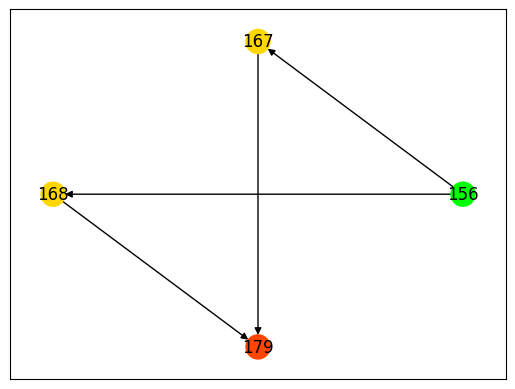

In [32]:
graph_existing_paths = nx.DiGraph()
graph_existing_paths.add_edges_from(df_existing_paths[['vertex0', 'vertex1']].values)

node_colors = {row['vertex']: critical_type_colors_dict[row['critical_type']] for irow, row in df_vertices.iterrows()}
node_color = [node_colors[node] for node in graph_existing_paths.nodes()]

pos = nx.circular_layout(graph_existing_paths)

nx.draw_networkx(graph_existing_paths, node_color=node_color, pos=pos)

In [33]:
if not 'degree' in df_vertices.columns:
    df_vertices = df_vertices.merge(pd.DataFrame(dict(graph_existing_paths.to_undirected().degree()).items(), columns=['vertex', 'degree']), on='vertex', how='left')

df_vertices[['critical_type', 'degree']].value_counts().reset_index().pivot_table(columns='critical_type', index='degree', values='count', fill_value=0).astype(int)

critical_type,max,min,saddle
degree,,,
2,1,1,2


In [34]:
p = mp.plot(vertices, faces, face_colors, shading={"wireframe": False})

for critical_type, color in critical_type_colors_dict.items():
    p.add_points(vertices[df_vertices.loc[df_vertices['critical_type'] == critical_type, 'vertex'].values], c=color, shading={"point_size": 1.0})

for path in df_existing_paths['path']:
    p.add_lines(vertices[path[1:]], vertices[path[:-1]], shading={'line_color': 'white'})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…